In [122]:
import astropy
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
import astropy.units as u
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.interpolate as interpolate
from astropy.table import Table


from astropy import table
from astropy.table import QTable
from tqdm import tqdm
from scipy.integrate import solve_bvp, odeint, solve_ivp
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

import smplotlib

In [214]:

def M_rho_deriv_degen(r_in_rsun, M_lrho, Z_on_A=0.5):
    """Find the Mass and density derivatives with respect to radius 
    for solving a degenerate star equation of state problem. 
    We have log(rho) as an input to help with numerics, as rho can never be 
    negative.
    
    Parameters
    ----------
    M_lrho: numpy array-like, including M in solar units, rho in g/cm^3.
    
    Returns
    -------
    derivatives: Derivatives of M in solar units, log(rho in g/cm^3), with respect 
        to r_in_rsun, as a numpy array-like variable.
    """
    M_in_Msun, lrho = M_lrho # lrho is the log of rho
    
    #Lets create a variable rho in real units
    rho = np.exp(lrho)*u.g/u.cm**3
    
    #Mass continuity equation! Convert to dimensionless units
    dM_in_Msundr = float(4*np.pi*r_in_rsun**2*rho * c.R_sun**3/c.M_sun)
    
    #Fermi momentum - a useful intermediate quantity in the semi-relativistic
    #equation of state
    p_F = ( c.h/2*(3*rho*Z_on_A/np.pi/u.u)**(1/3) ).cgs
    
    #Derivative of pressure with respect to density. 
    #dPdrho - should have units of (velocity)^2
    dPdrho = ( p_F**2*c.c/3/u.u/np.sqrt(p_F**2 + c.m_e**2*c.c**2) * Z_on_A ).cgs
    
    #drho/dr
    if r_in_rsun==0:
        dlrhodr = 0
    else:
        dlrhodr = -(c.G*M_in_Msun*c.M_sun/(r_in_rsun*c.R_sun)**2 / dPdrho)\
            .to(1/c.R_sun).value
    


    return np.array([dM_in_Msundr, dlrhodr])




print(M_rho_deriv_degen(1, [1, 1]))

    

[   5.78448162 -185.90718502]


# $ \frac{dM}{dr} = 4\pi r^2 \rho  $
# $ \frac{d\rho}{dr} = -\frac{GM}{r^2 \rho} $

# $ p_F =\frac{h}{2} \left( \frac{3 \rho Z}{\pi A m_u} \right)^{1/3} $
# $ \frac{dP}{dr} = \frac{p_F^2 c^2}{3 \sqrt{p_F^2 c^2 + m_e^2 c^4}} \frac{Z}{A} $


In [215]:
#%%
#The following function may be slightly confusing for people who aren't python or 
#object oriented programming experts, as variables (properties) are added to a function. 
#We can actually always add additional properties to functions, as all variables and
#functions in python are objects.
def near_surface(r_in_rsun, M_lrho):
    """Determine a surface condition by the surface becoming too cool. In practice, 
    our adiabatic approximation is likely to break before this!"""
    return M_lrho[1] - np.log(1e-2)


In [216]:

near_surface.terminal = True
near_surface.direction = -1

#%%

        
def wd_structure(rho_c):
    """Assuming a fully degenerate equation of state, compute the interior structure
    of a white dwarf, including its outer radius and mass.
    
    Parameters
    ----------
    rho_c: Central density, including units from astropy.units
    """
    #Start the problem at the white dwarf center.
    y0 = [0, np.log(rho_c.to(u.g/u.cm**3).value)] # r = 0 and rho = rho_c as initial conditions 
    
    #Don't go past 1 R_sun!
    rspan = [0,1] 


    #Solve the initial value problem!
    result = solve_ivp(M_rho_deriv_degen, [0,100], y0, events=[near_surface], method='RK23')  # events acts as a stopping condition near the surface
    # RK23: Explicit Runge-Kutta method of order 3(2)
    # result.t is the array of time points at which the solution was found
    # result.y is the array containing the value of y for each value of t
    # result.t_events is the array containing the time at which the event occurs
    # result.y_events is the array containing the value of y at the time of the event

    #Extract the results
    r_in_rsun = result.t
    M_in_Msun = result.y[0]
    rho = np.exp(result.y[1])*u.g/u.cm**3
    

    return r_in_rsun, M_in_Msun, rho, #result.t_events, result.y_events
    
    


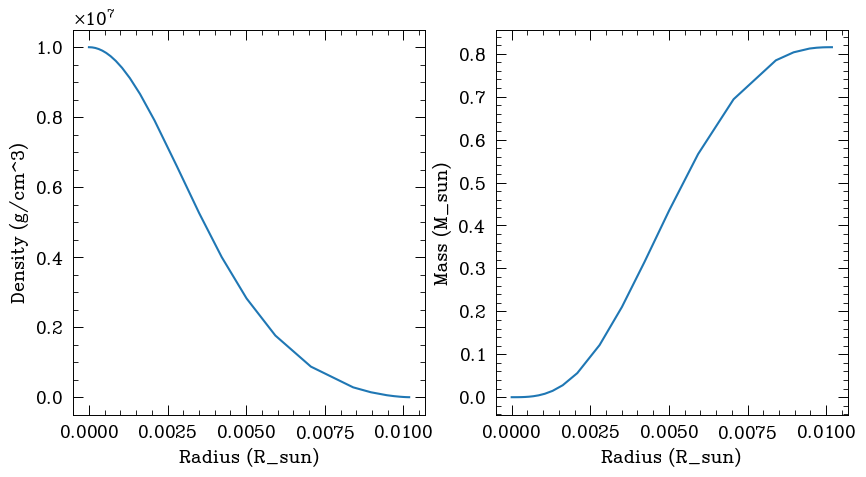

In [217]:

# %%
rho_c = 1e7*u.g/u.cm**3 # Central density


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(wd_structure(rho_c)[0], wd_structure(rho_c)[2])
ax1.set_xlabel('Radius (R_sun)')
ax1.set_ylabel('Density (g/cm^3)')
ax2.plot(wd_structure(rho_c)[0], wd_structure(rho_c)[1])
ax2.set_xlabel('Radius (R_sun)')
ax2.set_ylabel('Mass (M_sun)')
plt.show()


In [362]:
# convert rho in to electron number density
n_e = wd_structure(rho_c)[2]/(c.m_e)
print(n_e.cgs)


[1.09776911e+34 1.09723093e+34 1.09532213e+34 1.09197458e+34
 1.08695725e+34 1.07975843e+34 1.06948239e+34 1.05468363e+34
 1.03306027e+34 1.00081826e+34 9.51078525e+33 8.67897608e+33
 7.24375979e+33 5.77312670e+33 4.39296723e+33 3.09684844e+33
 1.93315804e+33 9.59621519e+32 3.09510522e+32 1.55097759e+32
 6.22871145e+31 3.35608399e+31 1.51096721e+31 8.28667437e+30
 4.02658097e+30 2.21715094e+30 1.14299611e+30 6.33971188e+29
 3.43005885e+29 1.93473613e+29 1.09144512e+29 6.32451991e+28
 3.71390604e+28 2.23107076e+28 1.36803912e+28 8.59688352e+27
 5.54659624e+27 3.68754174e+27 2.53690077e+27 1.81701341e+27
 1.36746989e+27 1.10058008e+27 8.53765809e+26 6.42194146e+26
 4.38658907e+26 2.91841113e+26 1.87398025e+26 1.16765221e+26
 7.08624067e+25 4.20085043e+25 2.43830082e+25 1.38834689e+25
 1.09776911e+25] 1 / cm3


#### Electron energy 

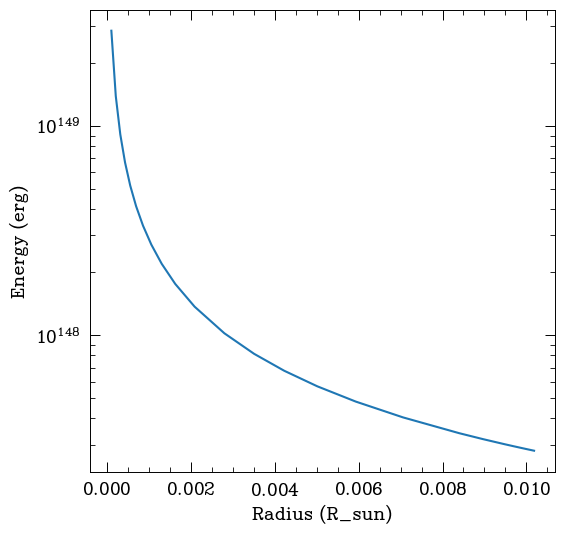

In [245]:
# electron energy with radius 
R = wd_structure(rho_c)[0] * c.R_sun
N = 1e40
E_e = c.h*c.c*N**(4.3) / (R)
# print(E_e.cgs)

# plot the energy with radius 
plt.plot(R.to(u.R_sun), E_e.cgs)
plt.xlabel('Radius (R_sun)')
plt.ylabel('Energy (erg)')
plt.yscale('log')
plt.show()


#### total energy density 

In [289]:
## total energy density 
p_F = ( c.h/2*(3*wd_structure(rho_c)[2]*0.5/np.pi/u.u)**(1/3) ).cgs
x_e = (p_F/(c.m_e*c.c)).cgs
#= 8π2􏳨3[xe 1+xe(1+2xe)−arcsinh(xe)],
DD =  (c.m_e**4 * c.c**5) / (8*np.pi**2 * c.hbar**3)
EE = x_e * (1 + x_e)**(1/2) * (1 + 2*x_e**2) 
FF = np.log(x_e + np.sqrt(1 + x_e**2)) # Identical to arcsinh(x_e)
E_tot = DD * (EE - FF)
E_tot = E_tot.cgs.to(u.erg/u.cm**3)

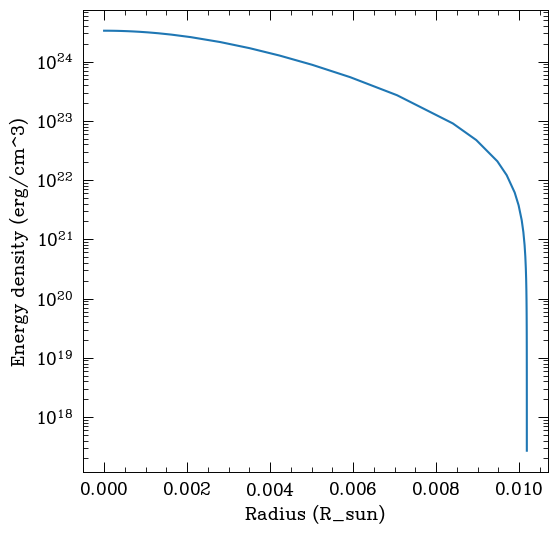

In [292]:
# plot total energy density with radius and with number density as a 1 by 2 plot 
plt.plot(R.to(u.R_sun), E_tot)
plt.xlabel('Radius (R_sun)')
plt.ylabel('Energy density (erg/cm^3)')
plt.yscale('log')
plt.show()



#### 

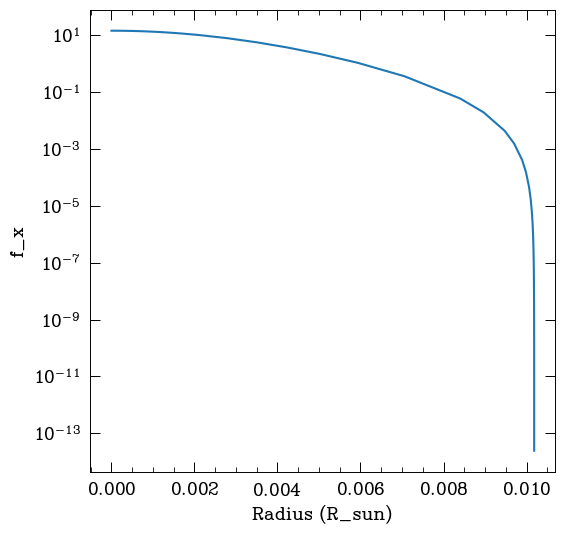

In [295]:
f_x = x_e * (2 * x_e**2 - 3) * (x_e**2 + 1)**(1/2) + 3 * np.log(x_e + np.sqrt(x_e**2 + 1))
f_x = f_x.cgs

# plot f_x with radius
plt.plot(R.to(u.R_sun), f_x)
plt.xlabel('Radius (R_sun)')
plt.ylabel('f_x')
plt.yscale('log')
plt.show()

In [363]:
# usinf P = n_e * k_B * T plot the temperature profile with n_e from above, calcaulting T

def Pmax(ne):
    Pmax1 = ((3 * ne * c.h**3) / (8 * np.pi))**(1/3)
    return Pmax1.cgs

def T_NR(ne):
    T_NR = (c.h**2/(2*np.pi*c.m_e*c.k_B)) * (3*ne/(8*np.pi))**(2/3)
    return T_NR.cgs.to(u.K)

def T_IR(ne):
    Pmax2 = Pmax(ne)
    y = Pmax2 / (c.m_e * c.c)
    A = (np.pi *c.m_e**4 * c.c**5 / (3 * c.h**3 * c.k_B))
    B = (y * np.sqrt(1 + y**2) * (2 * y**2 - 3) + 3 * np.log(y + np.sqrt(y**2 + 1)))
    P = (A * B)
    T_IR = P / (n_e * c.k_B)
    return T_IR.cgs

def T_ER(ne):
    P = (c.c *c.h) / (24 * np.pi**(1/3)) * (3 * ne)**(4/3)
    T_ER = P / (n_e * c.k_B)
    return T_ER.cgs.to(u.K)
    



In [364]:
T_ER(n_e)

<Quantity [3.93608309e+10, 3.93543977e+10, 3.93315635e+10, 3.92914539e+10,
           3.92311836e+10, 3.91443835e+10, 3.90198087e+10, 3.88389957e+10,
           3.85717322e+10, 3.81662066e+10, 3.75231580e+10, 3.63957009e+10,
           3.42674618e+10, 3.17710050e+10, 2.90054703e+10, 2.58147094e+10,
           2.20622454e+10, 1.74686998e+10, 1.19798780e+10, 9.51544487e+09,
           7.02036988e+09, 5.71265763e+09, 4.37836809e+09, 3.58388458e+09,
           2.81755716e+09, 2.30936375e+09, 1.85172081e+09, 1.52142459e+09,
           1.23973191e+09, 1.02431729e+09, 8.46371877e+08, 7.05618207e+08,
           5.90886717e+08, 4.98576386e+08, 4.23571530e+08, 3.62805841e+08,
           3.13498962e+08, 2.73614792e+08, 2.41543349e+08, 2.16112540e+08,
           1.96577216e+08, 1.82852600e+08, 1.68011951e+08, 1.52797426e+08,
           1.34566278e+08, 1.17474268e+08, 1.01348096e+08, 8.65628922e+07,
           7.32879470e+07, 6.15658193e+07, 5.13558220e+07, 4.25657138e+07,
           3.93608309e+07

In [365]:
T_NR(n_e)

<Quantity [6.65306110e+11, 6.65088650e+11, 6.64317076e+11, 6.62962852e+11,
           6.60930536e+11, 6.58009118e+11, 6.53827627e+11, 6.47782153e+11,
           6.38897636e+11, 6.25534098e+11, 6.04632878e+11, 5.68843984e+11,
           5.04262728e+11, 4.33465864e+11, 3.61287402e+11, 2.86172223e+11,
           2.09022201e+11, 1.31043101e+11, 6.16307975e+10, 3.88822323e+10,
           2.11647422e+10, 1.40142348e+10, 8.23223074e+09, 5.51570492e+09,
           3.40909000e+09, 2.29022253e+09, 1.47246171e+09, 9.94017102e+08,
           6.60007022e+08, 4.50569721e+08, 3.07620621e+08, 2.13812234e+08,
           1.49934457e+08, 1.06747179e+08, 7.70453655e+07, 5.65251258e+07,
           4.22051269e+07, 3.21493457e+07, 2.50543513e+07, 2.00563976e+07,
           1.65943160e+07, 1.43580438e+07, 1.21219740e+07, 1.00259393e+07,
           7.77616518e+06, 5.92622984e+06, 4.41086923e+06, 3.21778122e+06,
           2.30652469e+06, 1.62769235e+06, 1.13258907e+06, 7.78059548e+05,
           6.65306110e+05

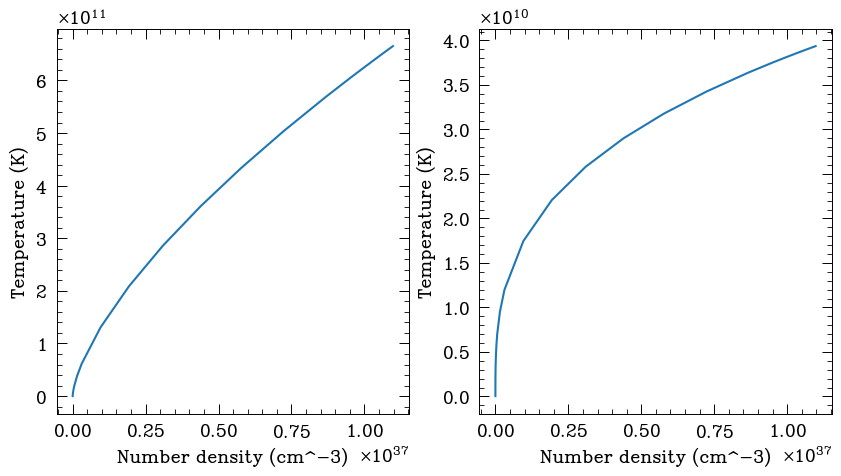

In [369]:
# plot the NR and ER temperature profiles with number density as a 1 by 2 plot 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(n_e, T_NR(n_e))
ax1.set_xlabel('Number density (cm^-3)')
ax1.set_ylabel('Temperature (K)')
ax2.plot(n_e, T_ER(n_e))
ax2.set_xlabel('Number density (cm^-3)')
ax2.set_ylabel('Temperature (K)')
plt.show()



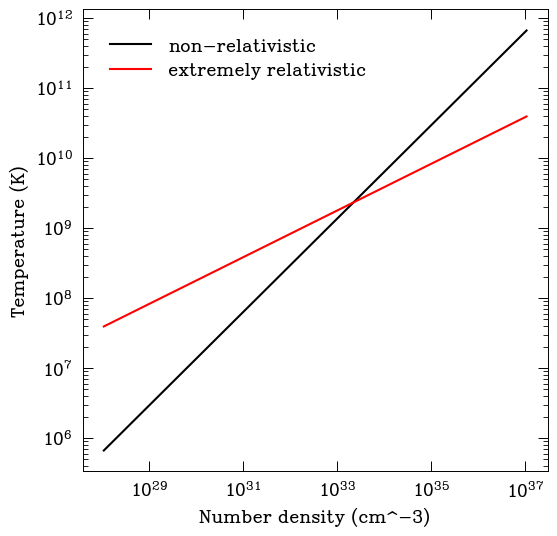

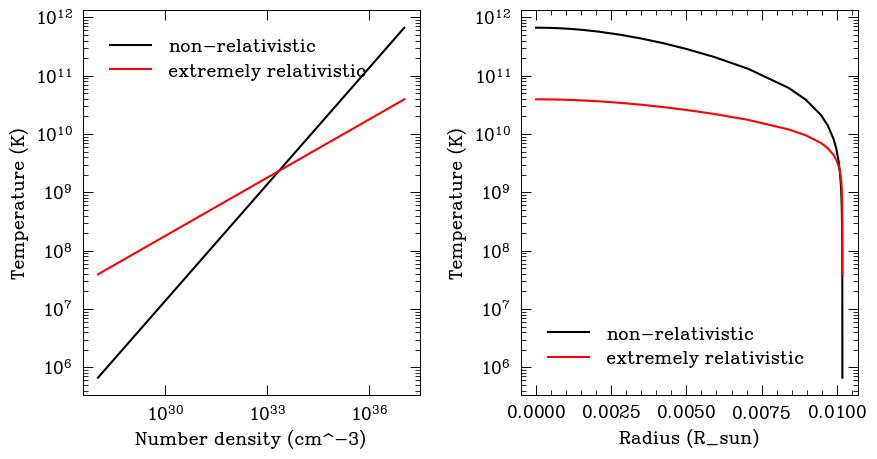

In [374]:
# # plot then all on the same plot
# plt.plot(n_e, T_NR(n_e), label='non-relativistic', color='k')
# # plt.plot(n_e, T_IR(n_e), label='IR')
# plt.plot(n_e, T_ER(n_e), label='extremely relativistic', color='r')
# plt.xlabel('Number density (cm^-3)')
# plt.ylabel('Temperature (K)')
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()
# plt.show()

# make a 1 by 2 plot of T_NR and T_ER with radius abd with number density as a 1 by 2 plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# add space between the plots
fig.subplots_adjust(wspace=0.3)
ax1.plot(n_e, T_NR(n_e), label='non-relativistic', color='k')
ax1.plot(n_e, T_ER(n_e), label='extremely relativistic', color='r')
ax1.set_xlabel('Number density (cm^-3)')
ax1.set_ylabel('Temperature (K)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()

ax2.plot(R.to(u.R_sun), T_NR(n_e), label='non-relativistic', color='k')
ax2.plot(R.to(u.R_sun), T_ER(n_e), label='extremely relativistic', color='r')
ax2.set_xlabel('Radius (R_sun)')
ax2.set_ylabel('Temperature (K)')
# ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
plt.show()



### Non-Ideal Temperature and $\nabla$

In [379]:

# Function for pressure in the non-relativistic regime
def pressure_NR(ne):
    PNR = (c.h**2 / (60 * np.pi**(2/3) * c.m_e)) * (3 * ne)**(5/3)
    return PNR.cgs


# Function for pressure in the extremely relativistic regime
def pressure_ER(ne):
    PER = (c.c *c.h) / (24 * np.pi**(1/3)) * (3 * ne)**(4/3)
    return PER.cgs



In [429]:
# Define the ODE function
def odefunc(T, r, P, G, M, rho, nabla):
    dTdr = -G * M * rho * nabla / (r**2 * P)
    return dTdr



##### for the ER regime
# Define parameters and initial conditions
P = pressure_ER(n_e).cgs.value  # Pressure
G = c.G.cgs.value  # Gravitational constant
M = wd_structure(rho_c)[1] # Mass
rho = wd_structure(rho_c)[2] # Density
nabla = 0.1/11 # nabla for fully ionisaed hydrogen
initial_T = T_ER(n_e) # Initial temperature guess as the ideal gas law 
r_values = np.linspace(0.0, 1, len(n_e))  # Radius values to solve the ODE at

# Solve the ODE using odeint
T_solution_ER = odeint(odefunc, initial_T, r_values, args=(P, G, M, rho, nabla))

# T_solution contains the temperature values at different r values


##### for the NR regime
# Define parameters and initial conditions
P = pressure_NR(n_e).cgs.value  # Pressure
initial_T = T_NR(n_e) # Initial temperature guess as the ideal gas law

# Solve the ODE using odeint
T_solution_NR = odeint(odefunc, initial_T, r_values, args=(P, G, M, rho, nabla))



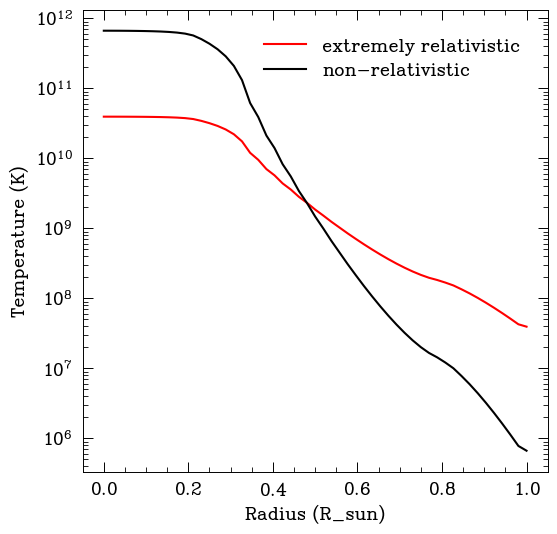

In [446]:
# Plot the solution
plt.plot(r_values, T_solution_ER[0], color='r', label='extremely relativistic')
plt.plot(r_values, T_solution_NR[0], label='non-relativistic', color='k')
plt.xlabel('Radius (R_sun)')
plt.ylabel('Temperature (K)')
plt.yscale('log')
plt.legend()
plt.show()


In [442]:
# solve for delta but with unknonw dt/dr for the ER regime

# Define parameters and initial conditions
r = np.linspace(0.0, 1, len(n_e)) 
density = wd_structure(rho_c)[2].cgs.value
P = pressure_ER(n_e).cgs.value

# Calculate the gradients using finite differences
dr = np.diff(r) 
ddensity_dr = np.gradient(density, dr) # this is finding the gradient of the density with respect to r with the spacing of dr between each point
dP_dr = np.gradient(P, dr) 


# Define constants
G = c.G.cgs.value  # Gravitational constant
M = wd_structure(rho_c)[1]


# Calculate A for each value of r
A_ER = np.zeros(len(r))
T = T_solution_ER[0]
for i in range(len(r)):
    # Approximate dT/dr using finite differences
    if i == 0:
        dT_dr = (T[i+1] - T[i]) / (r[i+1] - r[i])
    elif i == len(r) - 1:
        dT_dr = (T[i] - T[i-1]) / (r[i] - r[i-1])
    else:
        dT_dr = (T[i+1] - T[i-1]) / (r[i+1] - r[i-1])

    A_ER[i] = -r[i]**2 * P[i] / (G * M[i] * density[i]) * dT_dr

# Now, the A array contains the values of A for each corresponding value of r.


In [443]:
# solve for delta but with unknonw dt/dr for the NR regime

# Define parameters and initial conditions
r = np.linspace(0.0, 1, len(n_e))
density = wd_structure(rho_c)[2].cgs.value
P = pressure_NR(n_e).cgs.value

G = c.G.cgs.value  # Gravitational constant
M = wd_structure(rho_c)[1]

# Calculate the gradients using finite differences
dr = r[1] - r[0] # Assume constant spacing
ddensity_dr = np.gradient(density, dr)
dP_dr = np.gradient(P, dr)

# Calculate A for each value of r
A_NR = np.zeros(len(r))
T = T_solution_NR[0]
for i in range(len(r)):
    # Approximate dT/dr using finite differences
    if i == 0:
        dT_dr = (T[i+1] - T[i]) / (r[i+1] - r[i])
    elif i == len(r) - 1:
        dT_dr = (T[i] - T[i-1]) / (r[i] - r[i-1])
    else:
        dT_dr = (T[i+1] - T[i-1]) / (r[i+1] - r[i-1])

    A_NR[i] = -r[i]**2 * P[i] / (G * M[i] * density[i]) * dT_dr


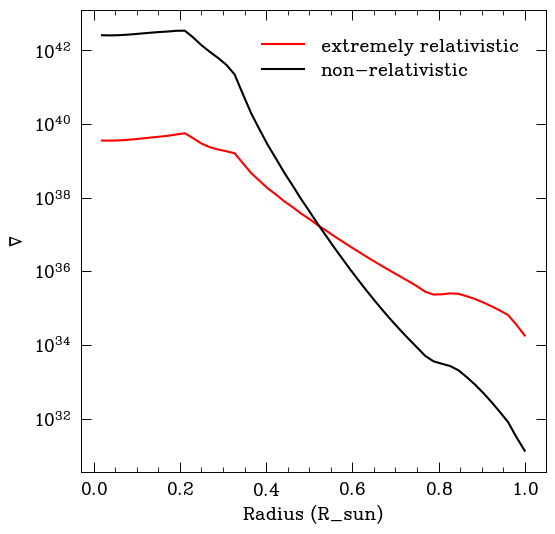

In [450]:
plt.plot(r, A_ER, color='r', label='extremely relativistic')
plt.plot(r, A_NR, label='non-relativistic', color='k')
plt.xlabel('Radius (R_sun)')
plt.ylabel('$\\nabla$')
plt.yscale('log')
plt.legend()
plt.show()



#### Radiative transfer under the diffusion approximation


In [ ]:
## Atempt to calculate the Rosseland mean opacity
from rapoc import Rosseland, Planck


# Define parameters and initial conditions
P = pressure_ER(n_e).to(u.Pa)
T = T_solution_ER[0] * u.K
wavelength_range = (500*u.nm, 1000*u.nm)


# Calculate the Rosseland mean opacity
k_R = Rosseland.estimate(P_input = P, T_input=T, band=wavelength_range,)
k_p = Planck.estimate(T_input=T, band=wavelength_range,)

# Plot the results
fig0, ax0 = Rosseland.estimate_plot(P_input = P, T_input=T, band=wavelength_range, mode='closest')
fig1, ax1 = Planck.estimate_plot(T_input=T, band=wavelength_range, mode='closest')
plt.show()

##### $ \mathcal{L} = \frac{16 \pi a cG}{3} \frac{T^4}{\kappa P} M(r) \nabla $
kappa = 1* u.cm**2 / u.g

def luminosity(kappa, T, P, M, r, nabla):
    a =  7.56577e-15 * u.erg / u.cm**3 / u.K**4
    L = 16 * np.pi * a * c.c  *c.G * M * T**4 *nabla / (3 * kappa * P)
    L = L.cgs 
    return L

# fro the ER case 
r =  np.linspace(0.0, 1, len(n_e)) *u.R_sun
M = wd_structure(rho_c)[1] * u.M_sun

L_ER = luminosity(kappa, T_solution_ER[0]*u.k, pressure_ER(n_e).cgs,M, r, A_ER)
L_NR = luminosity(kappa, T_solution_NR[0]*u.k, pressure_NR(n_e).cgs,M, r, A_NR)
plt.plot(r, L_ER, color='r', label='extremely relativistic')
plt.plot(r, L_NR, label='non-relativistic', color='k')
plt.xlabel('Radius (R_sun)')
plt.ylabel('$ \mathcal{L} $')
plt.yscale('log')
plt.legend()
plt.show()


##### $ \mathcal{L} = \frac{16 \pi a cG}{3} \frac{T^4}{\kappa P} M(r) \nabla $

In [ ]:
kappa = 1* u.cm**2 / u.g

def luminosity(kappa, T, P, M, r, nabla):
    a =  7.56577e-15 * u.erg / u.cm**3 / u.K**4
    L = 16 * np.pi * a * c.c  *c.G * M * T**4 *nabla / (3 * kappa * P)
    L = L.cgs 
    return L

# fro the ER case 
r =  np.linspace(0.0, 1, len(n_e)) *u.R_sun
M = wd_structure(rho_c)[1] * u.M_sun

L_ER = luminosity(kappa, T_solution_ER[0]*u.k, pressure_ER(n_e).cgs,M, r, A_ER)
L_NR = luminosity(kappa, T_solution_NR[0]*u.k, pressure_NR(n_e).cgs,M, r, A_NR)

In [ ]:
plt.plot(r, L_ER, color='r', label='extremely relativistic')
plt.plot(r, L_NR, label='non-relativistic', color='k')
plt.xlabel('Radius (R_sun)')
plt.ylabel('$ \mathcal{L} $')
plt.yscale('log')
plt.legend()
plt.show()

#### Saha equation - in pogress


In [457]:
T_e_ER = T_solution_ER[0] * u.K
E = 13.54*u.eV
n_II_n_i_ER = (2*np.pi*c.m_e*c.k_B*T_e_ER)**(3/2) / (c.h**3 * n_e) * np.exp(-E/(c.k_B*T_e_ER))


T_e_NR = T_solution_NR[0] * u.K
n_II_n_i_NR = (2*np.pi*c.m_e*c.k_B*T_e_NR)**(3/2) / (c.h**3 * n_e) * np.exp(-E/(c.k_B*T_e_NR))


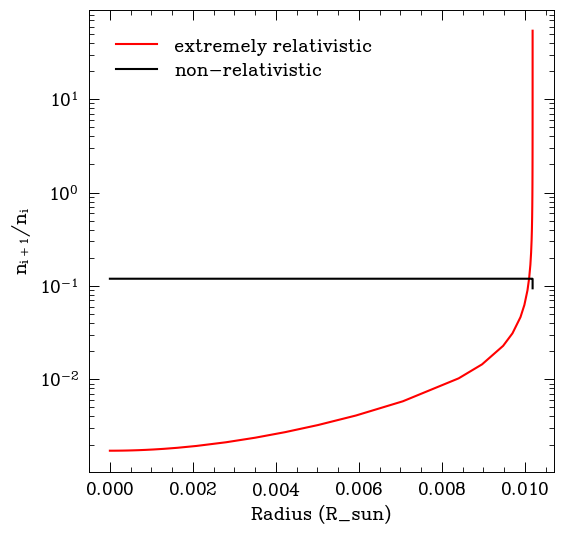

In [462]:
# plot saha vs radius
plt.plot(R.to(u.R_sun), n_II_n_i_ER.cgs, color='r', label='extremely relativistic')
plt.plot(R.to(u.R_sun), n_II_n_i_NR.cgs, label='non-relativistic', color='k')

plt.xlabel('Radius (R_sun)')
plt.ylabel('$n_{i+1}/n_{i}$')
plt.yscale('log')
plt.legend()
plt.show()


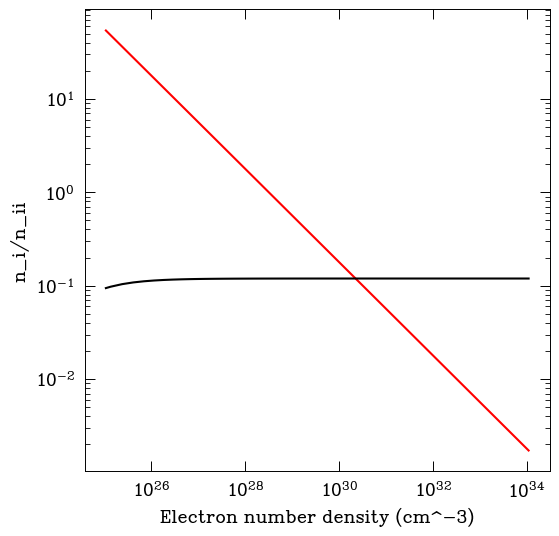

In [466]:
# plot saha vs n_e
plt.plot(n_e.cgs, n_II_n_i_ER.cgs, color='r', label='extremely relativistic')
plt.plot(n_e.cgs, n_II_n_i_NR.cgs, label='non-relativistic', color='k')
plt.xlabel('Electron number density (cm^-3)')
plt.ylabel('n_i/n_ii')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [126]:
from scipy.integrate import quad
from scipy.optimize import root_scalar
from scipy.optimize import brentq 


# Chemical potential solve 

In [211]:
### Constants here beecuse its just easier
h = (c.h).cgs.value
cc = (c.c).cgs.value
k = (c.k_B).cgs.value
m = (c.m_e).cgs.value

def integrand(p, mu, T):
    return (p**2) / (np.exp((-mu + m * cc**2 * np.sqrt(1 + (p/(m*cc))**2)) / (k * T)) + 1)

def calculate_n(mu, T):
    result, _ = quad(integrand, 0, np.inf, args=(mu, T))
    # print(f"mu = {mu}, T = {T}, n = {n}")
    return (8 * np.pi) / (h**3) * result


def calculate_mu(n, T):
    def f(mu):
        return calculate_n(mu, T) - n
    
    result = root_scalar(f, bracket=[0, 1e10])

    if result.converged:
        mu = result.root
    else:
        # Handle the case where convergence fails, e.g., raise an exception
        raise ValueError("Failed to converge in calculate_mu")
    return mu
    

In [213]:
ne_range = np.logspace(-1, 50, 10)
T = 1e7

# Solve for mu over the specified range
for ne in ne_range:
     mu = calculate_mu(ne, T)
     print(mu)

128630313.86677177
128630313.86677177
128630313.86677177
128630313.86677177
128630313.86677177
128630313.86677177
128630313.86677177
128630313.86677177
128630313.86677177
128630313.86677177


# Not sure about this 

### solve the pressure as a function of density

In [196]:
def Pmax(ne):
    return (3 * ne * h**3 / (8 * np.pi))**(1/3)

# Function for pressure in the non-relativistic regime
def pressure_NR(ne):
    return (h**2 / (60 * np.pi**(2/3) * m)) * (3 * ne)**(5/3)

# Function for pressure in the intermediate regime
def pressure_IR(ne):
    Pmax = Pmax(ne)
    y = Pmax / (m * cc)
    return (np.pi * m**4 * c**5 / (3 * h**3)) * (y * np.sqrt(1 + y**2) * (2 * y**2 - 3) + 3 * np.arcsinh(y))

# Function for pressure in the extremely relativistic regime
def pressure_ER(ne):
    return (cc * h / (24 * np.pi**(1/3))) * (3 * ne)**(4/3)

In [197]:
# solve for the n from the integral adn then use that to solve for the pressure
def pressure(ne):
     n = calculate_n(mu_solved, T)
    
     print(n)
     if Pmax(n) < 0.001 * m * cc:
         return pressure_NR(n)
     elif Pmax(n) > 100 * m * cc:
         return pressure_ER(n)
     else:
         return pressure_IR(n)


mu = 128630313.86677177, T = 10000.0, n = 0.0
mu = 128630313.86677177, T = 10974.987654930568, n = 0.0
mu = 128630313.86677177, T = 12045.035402587811, n = 0.0
mu = 128630313.86677177, T = 13219.411484660288, n = 0.0
mu = 128630313.86677177, T = 14508.287784959402, n = 0.0
mu = 128630313.86677177, T = 15922.82793341094, n = 0.0
mu = 128630313.86677177, T = 17475.28400007683, n = 0.0
mu = 128630313.86677177, T = 19179.10261672489, n = 0.0
mu = 128630313.86677177, T = 21049.04144512022, n = 0.0
mu = 128630313.86677177, T = 23101.29700083158, n = 0.0
mu = 128630313.86677177, T = 25353.644939701113, n = 0.0
mu = 128630313.86677177, T = 27825.59402207126, n = 0.0
mu = 128630313.86677177, T = 30538.555088334124, n = 0.0
mu = 128630313.86677177, T = 33516.02650938841, n = 0.0
mu = 128630313.86677177, T = 36783.79771828634, n = 0.0
mu = 128630313.86677177, T = 40370.17258596558, n = 0.0
mu = 128630313.86677177, T = 44306.21457583878, n = 0.0
mu = 128630313.86677177, T = 48626.015800653535, n =

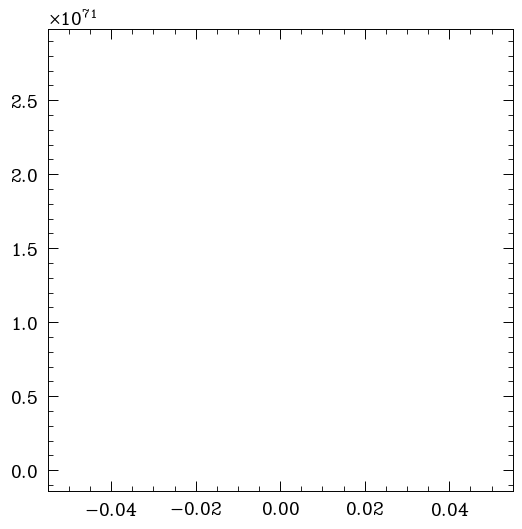

In [203]:
T = np.logspace(4, 8, 100)
for i in T:
    plt.plot(calculate_n(mu_solved, i))

plt.show()

In [ ]:
# Plot the pressure as a function of ne
ne_range = np.logspace(-1, 50, 100)
plt.plot(ne_range, pressure(ne_range))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ne')
plt.ylabel('Pressure')
plt.show()



# Chandrasekhar method for a white dwarf

In [62]:
def fermi_dirac_rel(p):
    E = c.m_e.value * (c.c.value)**2 * np.sqrt(1 + (p / (c.m_e.value * c.c.value))**2)
    T = 10**7
    mu = 2
    return 4*np.pi / ((c.h.value)**3) * 1/(np.exp((E - mu) / (c.k_B.value * T)) + 1)



In [69]:
# Solve for n 
n = quad(fermi_dirac_rel, 0.001,1000)
print(n)

(0.0, 0.0)


In [88]:
def odes(yz, r, G, B, A):
    y, z = yz  # Unpack y and z
    dydr = z
    dzdr = -np.pi * (G * B**2 / (2 * A)) * (y**2 - 1)**(3/2) / r**2
    return [dydr, dzdr]



In [96]:
G = 6.67430e-11   # Gravitational constant (m^3/kg/s^2)
B = 9.82e5
A = 6.9e22
r_values = np.linspace(0, 1, 1000)


In [106]:
y0 = 10  # Initial condition for y at r0
z0 = 0  # Initial condition for z (dy/dr) at r0
initial_conditions = [y0, z0]


In [107]:
solutions = odeint(odes, initial_conditions, r_values, args=(G, B, A))
y_values, z_values = solutions.T
print(y_values)
print(z_values)


[ 1.00000000e+001              nan              nan  6.95046857e-310
  6.95046613e-310 -9.73136599e+298  2.16910875e-314  6.95046554e-310
  1.58843807e-289  6.95046611e-310  6.95046554e-310  1.46394981e-305
  0.00000000e+000  0.00000000e+000  1.46394981e-305  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000

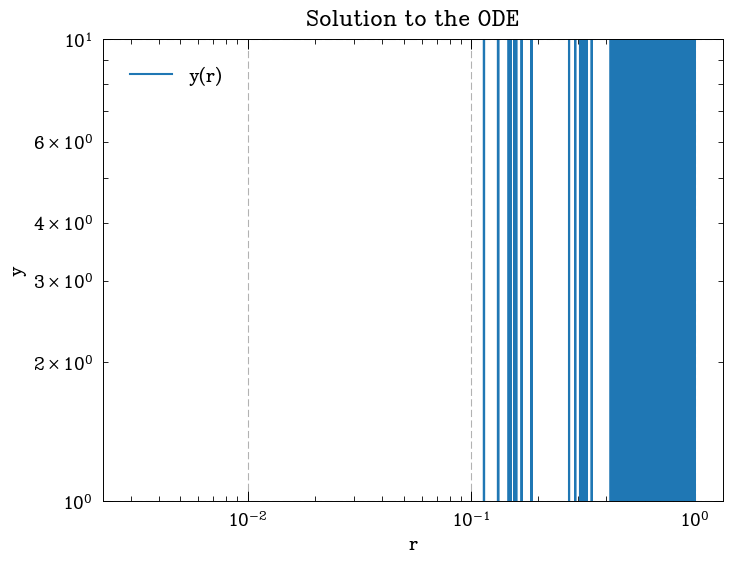

In [109]:
plt.figure(figsize=(8, 6))
plt.plot(r_values, y_values, label='y(r)')
plt.xlabel('r')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title('Solution to the ODE')
plt.show()


In [45]:

# Constants
# ------------------------------------------------
K=1.0 # polytrope K
n=3.0 # polytropic index
exponent = ((n+1)/n)
G=1.0 # Newton's constant
# ------------------------------------------------


def get_rho(P):
    """The equation of state gives ensity a function of pressure.
    We assume a polytropic equation of state:
    P = K*rho**((n+1)/n)
    which we invert"""
    out = P/K
    rho = np.abs(out)**(1/exponent)
    return rho

def rhs(r,v):
    """Right-hand side
    takes in vector (M,P)
    and returns dM/dr, dP/dr
    also requires radius r"""
    M,P = v
    rho = get_rho(P)
    dmdr=4*np.pi*r*r*rho
    dpdr = - G*M*rho/(r*r)
    return np.array([dmdr,dpdr])

def forward_euler_step(r,v,dr):
    """Uses the stellar structure equations
    to integrate outward from the center of the star"""
    dv = dr*rhs(r,v)
    return v + dv

def integrate_test(p0,dr):
    """Gives us the final radius to integrate to."""
    M0 = 0
    r0 = dr
    P0 = p0
    v = np.array([M0,P0])
    r = r0
    nr = 0
    while v[1] > 0:
        v = forward_euler_step(r,v,dr)
        r +=  dr
        nr += 1
    return r,nr

def integrate_final(p0,dr,nr):
    """Once we know the final radius, we integrate to it
    and store our data."""
    M0 = 0
    r0 = dr
    P0 = p0
    v0 = np.array([M0,P0])
    r = np.arange(dr,(nr+1)*dr,dr)
    v = np.empty((nr,2),dtype=float)
    v[0,...] = v0
    for i in range(1,nr):
        v[i,...] = forward_euler_step(r[i-1],v[i-1],dr)
    return r,v

def plot_profile(r,v):
    m = v[...,0]
    p = v[...,1]
    rho = get_rho(p)
    plt.plot(r,m,lw=3)
    plt.plot(r,p,lw=3)
    plt.plot(r,rho,lw=3)
    plt.xlabel('radius',fontsize=20)
    plt.legend(['mass','pressure','density'],
               fontsize=20,
               loc = 'lower right')
    plt.savefig('star_profile.pdf',
                bbox_inches='tight')


In [46]:
p0 = 1.4
dr = 0.001
rmax,nr = integrate_test(p0,dr)
r,v = integrate_final(p0,dr,nr)
plot_profile(r,v)

# Eric's code

In [22]:
def idealElectronPressure(n_e, T):
    return n_e * c.k_B * T


def fullyDegenElectronPressure_routine(n_e, mu_e, thresh):
    # Eqn 37 in Mike's notes
    p_max = (3 * n_e * c.h**3 / 8 / np.pi)**(1/3)
    
    if p_max < thresh * c.m_e * c.c:
        return calculate_non_relativistic_pressure_routine(n_e)
    elif thresh * p_max > c.m_e * c.c:
        return calculate_extreme_relativistic_pressure_routine(n_e)
    else:
        return calculate_intermediate_pressure_routine(n_e, p_max)
    
def calculate_non_relativistic_pressure_routine(n_e):
    # Eqn 43 in Mike's notes
    P_e = c.h**2 / 60 / np.pi**(2/3) / c.m_e * (3 * n_e)**(5/3)
    regime = 'NR'
    return [n_e.si.value, P_e.si.value, regime]

def calculate_extreme_relativistic_pressure_routine(n_e):
    # Eqn 45 in Mike's notes
    P_e = c.c * c.h / 24 / np.pi**(1/3) * (3 * n_e)**(4/3)
    regime = 'ER'
    return [n_e.si.value, P_e.si.value, regime]

def calculate_intermediate_pressure_routine(n_e, p_max):
    # Eqn 47 in Mike's notes
    y = (p_max / c.m_e / c.c).si
    P_e = np.pi * c.m_e**4 * c.c**5 / 3 / c.h**3 * (y * (1 + y**2)**(1/2) * (2 * y**2 - 3) + 3 * np.arcsinh(y).value)
    regime = 'IN'
    return [n_e.si.value, P_e.si.value, regime]

def fullyDegenElectronPressure(n_e, mu_e=2, thresh=0.001):
    # Check if input has multiple values (numpy array, list, etc.)
    if type(n_e.value) == np.ndarray or type(n_e.value) == list:
        output = []
        
        # Calculate pressure for each value of n_e
        for i, n in enumerate(n_e):
            output.append(fullyDegenElectronPressure_routine(n, mu_e, thresh))
        
    else:
        output = fullyDegenElectronPressure_routine(n_e, mu_e, thresh)
    
    # Create QTable with appropriate units and dtype
    return table.QTable(np.asarray(output), names=['n_e', 'P_e', 'regime'],
                    units=[1/u.m**3, u.N/u.m**2, None], dtype=['f8', 'f8', 'S2'],
                    meta={'regime': ['non-relativistic', 'extreme-relativistic', 'intermediate']})
    
def calculate_extreme_relativistic_pressure(n_e):
    if type(n_e.value) == np.ndarray or type(n_e.value) == list:
        output = []
        
        # Calculate pressure for each value of n_e
        for i, n in enumerate(n_e):
            output.append(calculate_extreme_relativistic_pressure_routine(n))
        
    else:
        output = calculate_extreme_relativistic_pressure_routine(n_e)
    
    # Create QTable with appropriate units and dtype
    return table.QTable(np.asarray(output), names=['n_e', 'P_e', 'regime'],
                    units=[1/u.m**3, u.N/u.m**2, None], dtype=['f8', 'f8', 'S2'],
                    meta={'regime': ['non-relativistic', 'extreme-relativistic', 'intermediate']})

def calculate_non_relativistic_pressure(n_e):
    if type(n_e.value) == np.ndarray or type(n_e.value) == list:
        output = []
        
        # Calculate pressure for each value of n_e
        for i, n in enumerate(n_e):
            output.append(calculate_non_relativistic_pressure_routine(n))
        
    else:
        output = calculate_non_relativistic_pressure_routine(n_e)
    
    # Create QTable with appropriate units and dtype
    return table.QTable(np.asarray(output), names=['n_e', 'P_e', 'regime'],
                    units=[1/u.m**3, u.N/u.m**2, None], dtype=['f8', 'f8', 'S2'],
                    meta={'regime': ['non-relativistic', 'extreme-relativistic', 'intermediate']})

def calculate_intermediate_pressure(n_e):
    if type(n_e.value) == np.ndarray or type(n_e.value) == list:
        output = []
        
        # Calculate pressure for each value of n_e
        for i, n in enumerate(n_e):
            p_max = (3 * n * c.h**3 / 8 / np.pi)**(1/3)
            output.append(calculate_intermediate_pressure_routine(n, p_max))
        
    else:
        output = calculate_intermediate_pressure_routine(n_e, p_max)
    
    # Create QTable with appropriate units and dtype
    return table.QTable(np.asarray(output), names=['n_e', 'P_e', 'regime'],
                    units=[1/u.m**3, u.N/u.m**2, None], dtype=['f8', 'f8', 'S2'],
                    meta={'regime': ['non-relativistic', 'extreme-relativistic', 'intermediate']})
    

In [23]:
number_density_range = np.logspace(1, 50, 100) / u.cm ** 3

fullyDegenElectronPressure(number_density_range)

NR_reg = fullyDegenElectronPressure(number_density_range)[fullyDegenElectronPressure(number_density_range)['regime'] == 'NR']
ER_reg = fullyDegenElectronPressure(number_density_range)[fullyDegenElectronPressure(number_density_range)['regime'] == 'ER']
IN_reg = fullyDegenElectronPressure(number_density_range)[fullyDegenElectronPressure(number_density_range)['regime'] == 'IN']